In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ReadRiteEval Tester

In [11]:
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import emoji
import warnings
load_dotenv()

from objects import *
from utils import *
from models import query_model, model_list, together_model_list, openai_model_list, model_sizes


warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 300
all_emojis = list(emoji.EMOJI_DATA.keys())
bad_models = ["zephyr-7b-beta", "yi-34b-chat", "falcon-40b-instruct", "falcon-7b-instruct", "chronos-hermes-13b"]
print(len(model_list))

38


In [12]:
with open("scores.json", "r") as f:
    scores = [TestScore.model_validate(score) for score in json.load(f)]

## Sequence Logic Puzzle

In [7]:
## Load puzzles from JSON.
with open("sequence_logic.json", "r") as f:
    puzzles = [Puzzle.model_validate(puzzle) for puzzle in json.load(f)]

## Sample puzzle.
puzzles[0]

Puzzle(rules='In this puzzle, use the symbols 👶 (Baby), 🍼 (Baby Bottle), 🧸 (Teddy Bear), 🎈 (Balloon), 🎁 (Gift), and 🎂 (Birthday Cake).\n1. 👶 cannot be directly before or after 🎁.\n2. 🍼 must always precede 🧸 but follow 👶.\n3. 🎈 must be immediately after 🧸.\n4. The sequence must start with 👶.\n5. 🎂 cannot be adjacent to either 👶 or 🍼.\n6. The sequence contains exactly one of each symbol.\n7. 🎁 must be the last in the sequence.', answer='👶, 🍼, 🧸, 🎈, 🎂, 🎁', validation=PuzzleValidator(analysis="The proposed sequence starts with 👶, which complies with rule 4. The condition of rule 2 that 🍼 must follow 👶 is also satisfied. 🍼 also precedes 🧸 in the sequence, thus fully satisfying rule 2. 🎈 is immediately after 🧸, following rule 3. The sequence ends with 🎁, which satisfies rule 7. 👶 is not directly before or after 🎁, thus following rule 1. 🎂 is not adjacent to either 👶 or 🍼, thus it's compliant with rule 5. Lastly, the sequence contains exactly one of each symbol which is rule 6. Therefore the 

In [118]:
for full_model_name in ["una-cybertron-7b-v2-bf16"]: #together_model_list + openai_model_list:        
    if full_model_name.split("/")[-1].lower() in [score.model for score in scores if score.test == "sequence_logic_puzzle"] + bad_models:
        continue

    score = []
    full_answers = []
    print(full_model_name)
    for puzzle in tqdm(puzzles):
        correct_answer = "".join([char for char in puzzle.answer if char in all_emojis])

        messages=[{"role": "user", "content": puzzle.question_prompt()}]
        full_answer = query_model(full_model_name, messages, temperature=0., max_tokens=50) #, stop=["\n"])
        answer = "".join([char for char in full_answer if char in all_emojis])
        # answer = answer[:len(correct_answer)]
        
        ## Validate answer.
        # correct = answer == correct_answer
        correct = correct_answer in answer
        score.append(correct)
        full_answers.append(full_answer)
        
    print(sum(score)/len(score))
    
    ## Store in local JSON.
    if "/" in full_model_name:
        model_name = full_model_name.split("/")[-1]
    else:
        model_name = full_model_name
    model_score = TestScore(
        test="sequence_logic_puzzle",
        model=model_name.lower(),
        individual_scores=score,
        total_score=sum(score)/len(score),
        full_answers=full_answers
    )
    
    scores.append(model_score)
    
    ## Store locally with all other scores.
    with open("scores.json", "w") as f:
        json.dump([score.model_dump() for score in scores], f)

una-cybertron-7b-v2-bf16


  0%|          | 0/83 [00:00<?, ?it/s]

0.37349397590361444


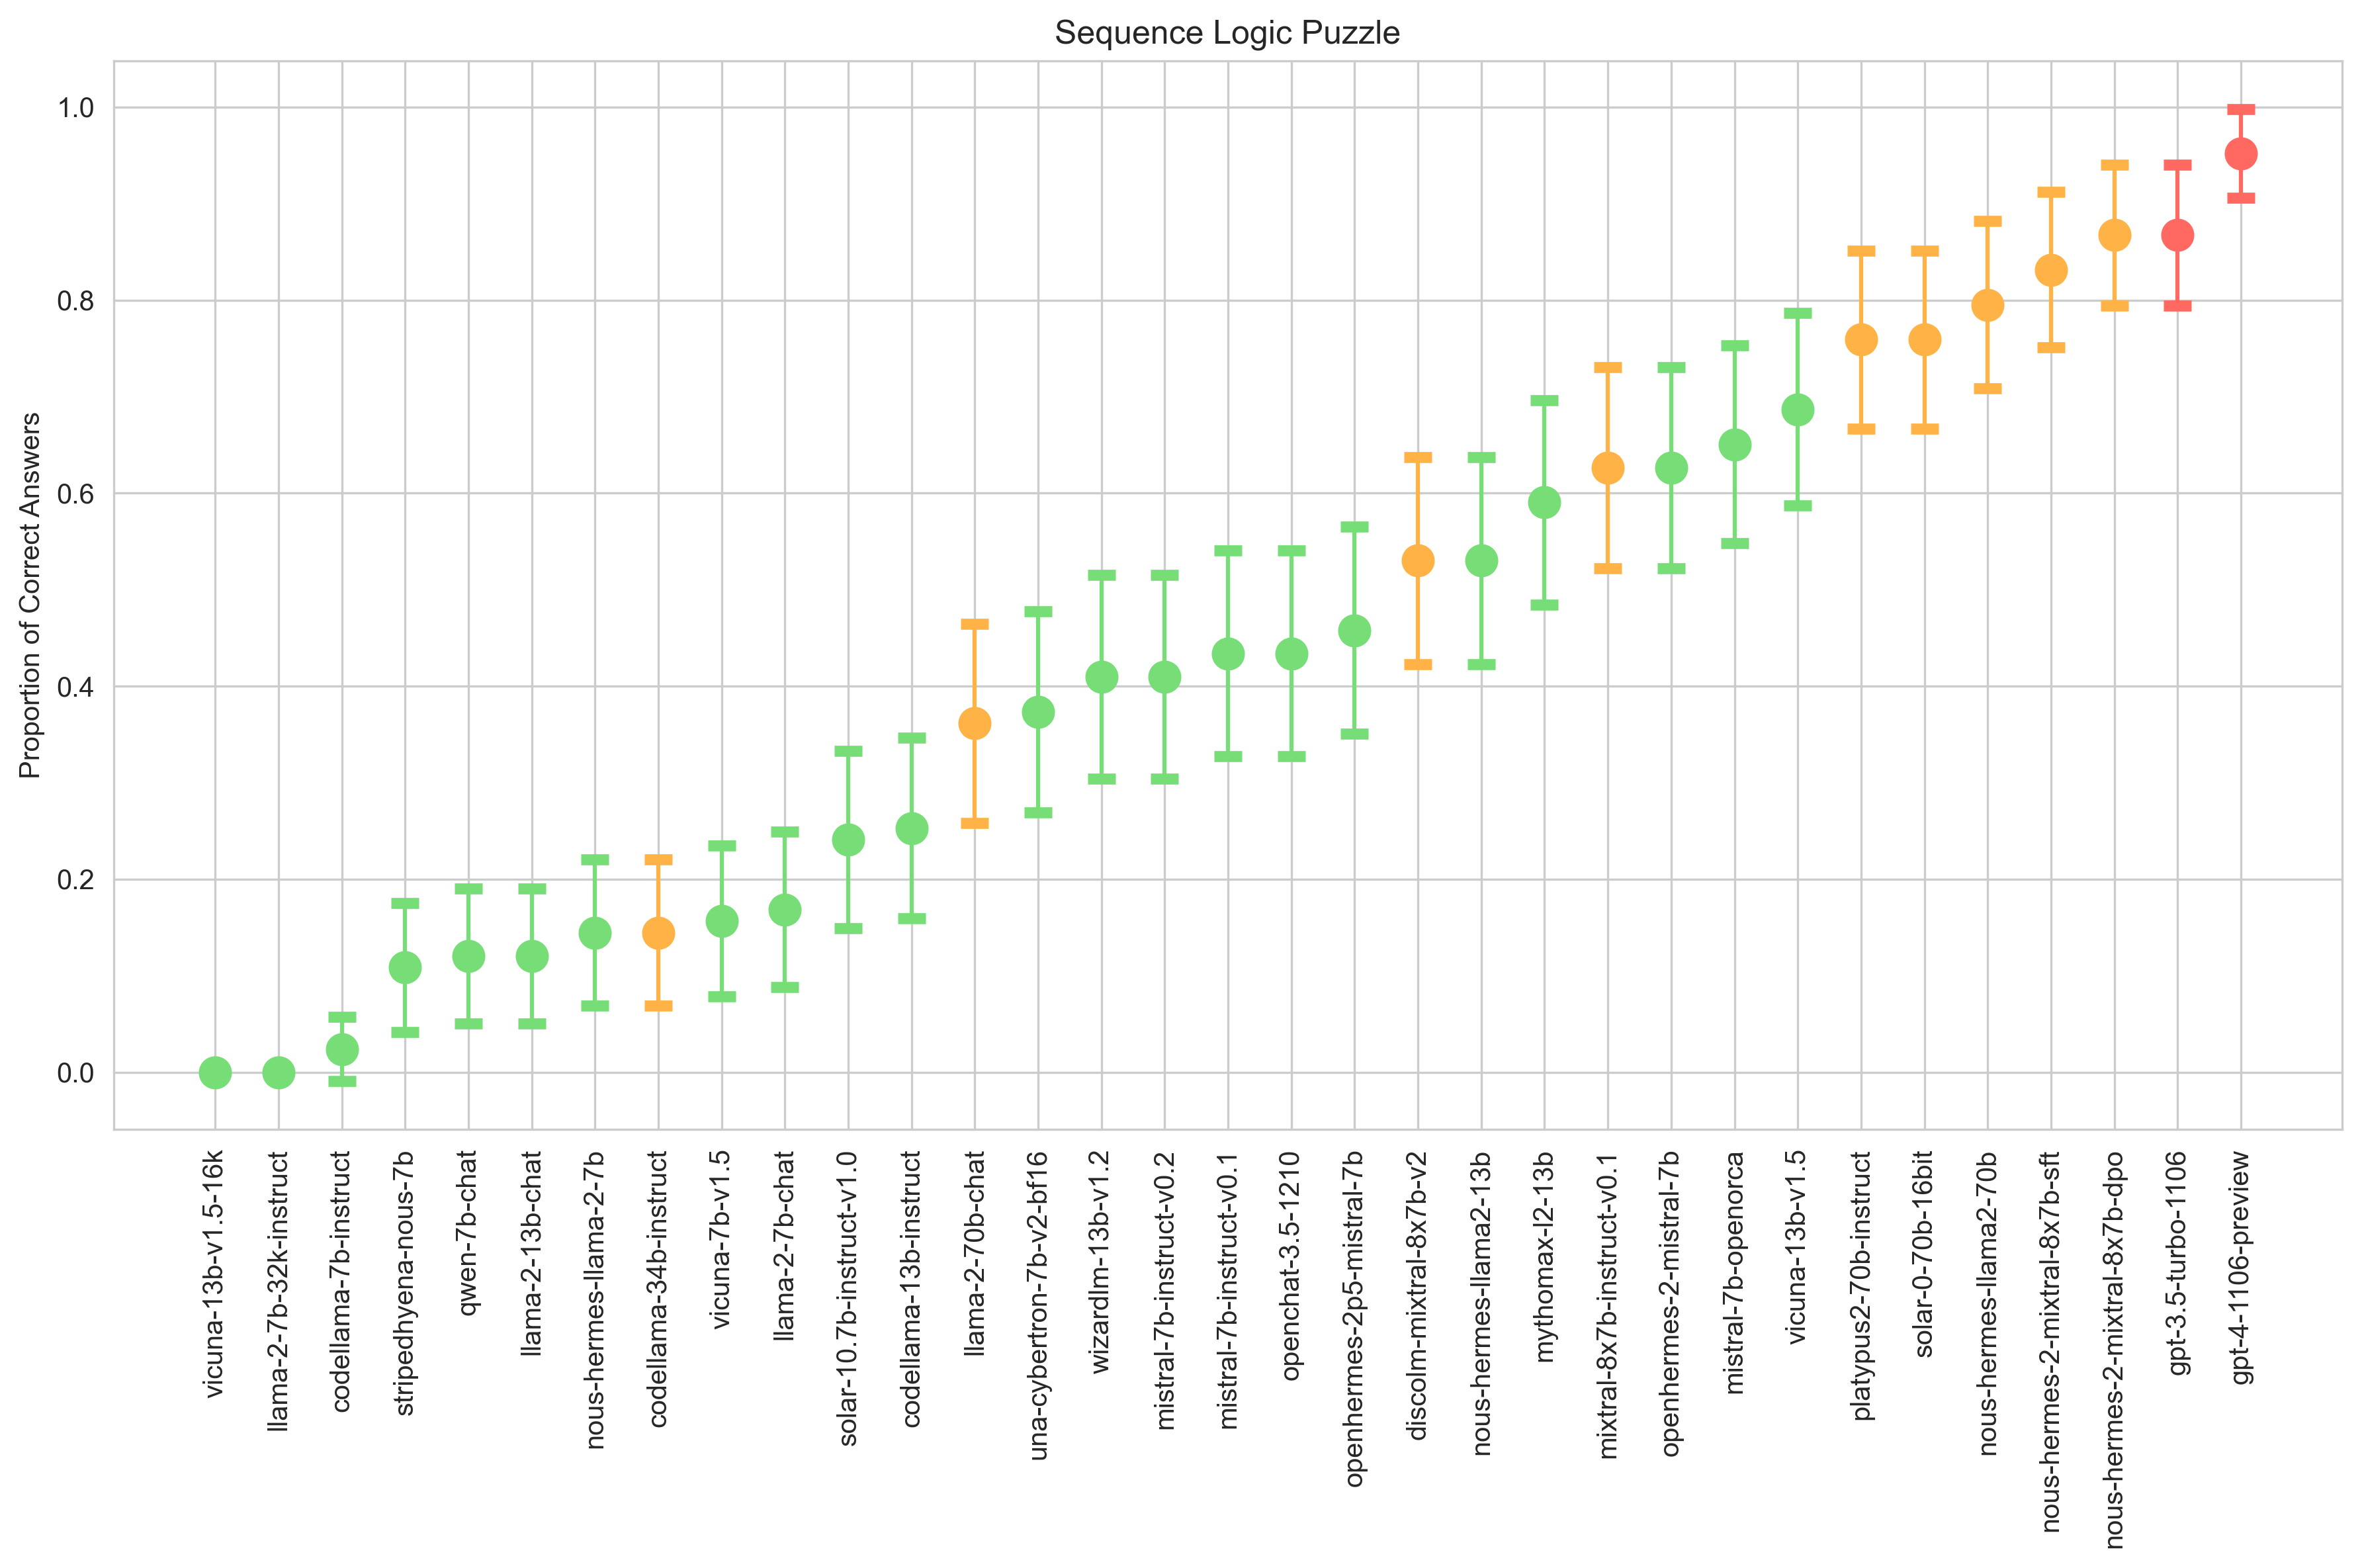

In [18]:
plot_scores("sequence_logic_puzzle", scores, model_sizes, bad_models);

 ## Contextual Dissonance

In [11]:
## Load passages from JSON.
with open("contextual_dissonance.json", "r") as f:
    passages = [ContextualPassage.model_validate(passage) for passage in json.load(f)]
    
passages[0]

ContextualPassage(topic='The Evolution of Renewable Energy Sources', irrelevant_topic='The Popularity of Organic Food Products', passage="The evolution of renewable energy sources has been a cornerstone in the quest for sustainable development and environmental preservation. From the early harnessing of water and wind power to the modern advancements in solar and geothermal energy, the journey has been marked by continuous innovation and technological breakthroughs. The introduction of solar panels has particularly transformed the energy landscape, allowing for the direct conversion of sunlight into electricity, thereby reducing reliance on fossil fuels and diminishing greenhouse gas emissions.\n\nAs the world's energy demands continue to rise, the importance of diversifying energy sources cannot be overstated. Wind turbines have become a common sight in many parts of the world, capitalizing on the natural movement of air to generate power. This shift towards renewable sources is not o

In [90]:
rerun_name = "una-cybertron-7b-v2-bf16"
scores = delete_score(scores, rerun_name, "contextual_dissonance")

Deleted 1 scores.


In [98]:
for model_name in together_model_list + openai_model_list:
            
    if model_name.split("/")[-1].lower() in [score.model for score in scores if score.test == "contextual_dissonance"] + bad_models:
        continue

    score = []
    full_answers = []
        
    print(model_name)
    for passage in tqdm(passages):
        messages=[{"role": "user", "content": passage.question_prompt()}]
        full_answer = query_model(model_name, messages, temperature=0., max_tokens=50)
        correct_answer = passage.irrelevant_sentence
        
        ## Validate answer.
        # correct = sentences_match(correct_answer, full_answer, tolerance=7)
        # correct = tfidf_embedding_similarity(correct_answer, full_answer) > 0.9
        correct = hf_embedding_similarity(correct_answer, full_answer) > 0.91
        score.append(correct)
        full_answers.append(full_answer)
        
    ## Status.
    print(sum(score)/len(score))
    
    ## Store in local JSON.
    if "/" in model_name:
        model_name = model_name.split("/")[-1]
    model_score = TestScore(
        test="contextual_dissonance",
        model=model_name.lower(),
        individual_scores=score,
        total_score=sum(score)/len(score),
        full_answers=full_answers
    )
    
    scores.append(model_score)
    
    ## Store locally with all other scores.
    with open("scores.json", "w") as f:
        json.dump([score.model_dump() for score in scores], f)

upstage/solar-10.7b-instruct-v1.0


  0%|          | 0/50 [00:00<?, ?it/s]

0.56
gpt-3.5-turbo-1106


  0%|          | 0/50 [00:00<?, ?it/s]

0.94
gpt-4-1106-preview


  0%|          | 0/50 [00:00<?, ?it/s]

0.98


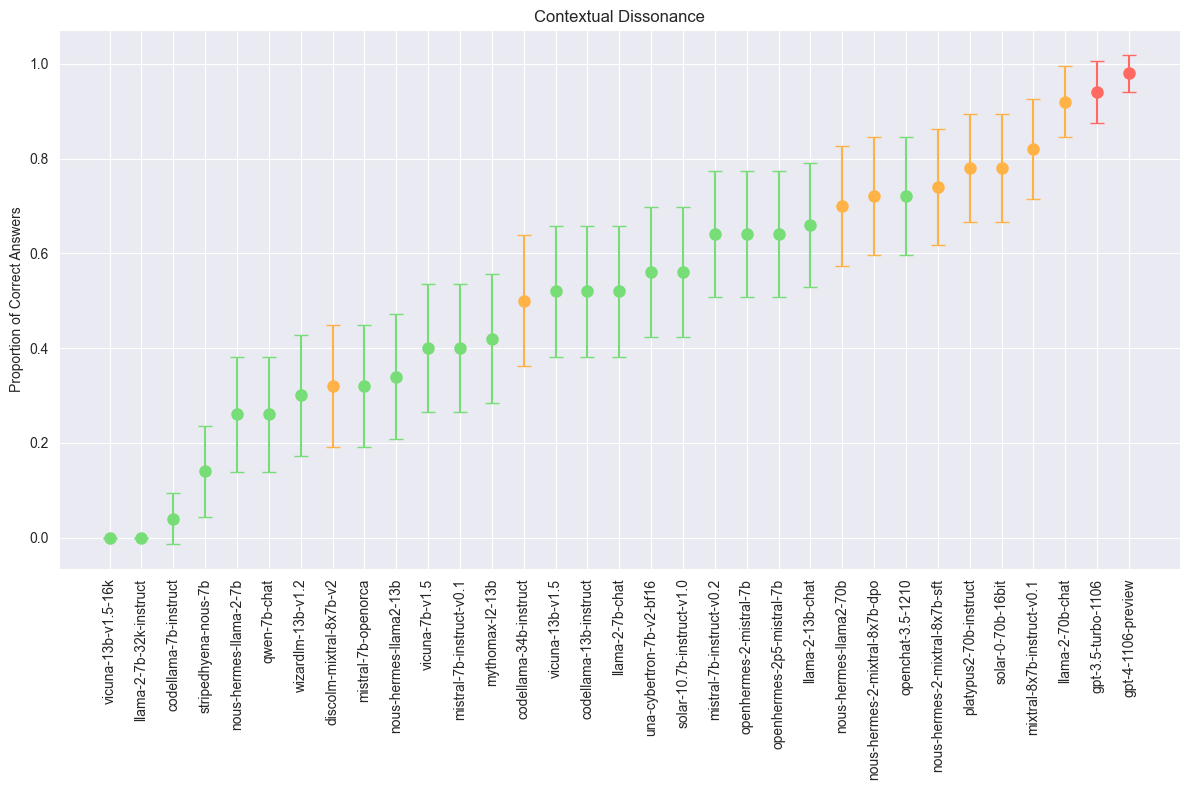

In [10]:
plot_scores("contextual_dissonance", scores, model_sizes, bad_models);

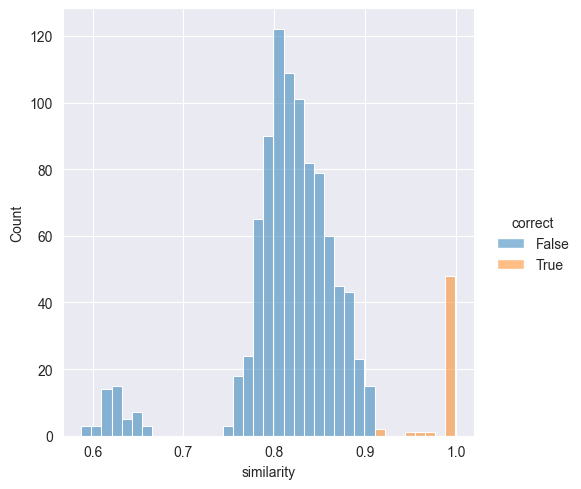

In [168]:
all_scores = []
for passage in tqdm(passages):
    sentences = passage.passage.split(".")
    for sentence in sentences:
        sim = hf_embedding_similarity(passage.irrelevant_sentence, sentence)
        correct = sim > 0.91
        all_scores.append((sim, correct))

sim_df = pd.DataFrame(all_scores, columns=["similarity", "correct"])
sns.displot(sim_df, x="similarity", hue="correct",  fill=True);

## Spatial Navigation & Reasoning

In [8]:
## Load cities from JSON.
with open("spatial_reasoning.json", "r") as f:
    cities = [City.model_validate(city) for city in json.load(f)]

In [14]:
for model_name in together_model_list + openai_model_list:
    if model_name.split("/")[-1].lower() in [score.model for score in scores if score.test == "spatial_reasoning"] + bad_models:
        continue

    score = []
    full_answers = []
    full_validations = []

    print(model_name)
    for city in tqdm(cities):
        for qna in city.qna:
            messages=[{"role": "user", "content": qna.question_prompt(city.description)}]
            full_answer = query_model(model_name, messages, temperature=0., max_tokens=100)
            
            ## Validate answer.
            # messages_validation=[{"role": "user", "content": qna.validation_prompt(city_layout=city.description, answer=full_answer)}]
            # answer_validator = query_model("gpt-4-1106-preview", messages, temperature=0., max_tokens=500, response_model=CityQnaValidator)
            # correct = answer_validator.valid
            correct = subword_cosine_similarity(qna.answer, full_answer) > 0.9
            score.append(correct)
            full_answers.append(full_answer)
            # full_validations.append(answer_validator)
                
    ## Status.
    print(sum(score)/len(score))
    
    ## Store in local JSON.
    if "/" in model_name:
        model_name = model_name.split("/")[-1]
    model_score = TestScore(
        test="spatial_reasoning",
        model=model_name.lower(),
        individual_scores=score,    
        total_score=sum(score)/len(score),
        full_answers=full_answers,
        # full_validations=full_validations
    )
    
    scores.append(model_score)
    
    ## Store locally with all other scores.
    with open("scores.json", "w") as f:
        json.dump([score.model_dump() for score in scores], f)

gpt-3.5-turbo-1106


  0%|          | 0/98 [00:00<?, ?it/s]

0.3434650455927052
gpt-4-1106-preview


  0%|          | 0/98 [00:00<?, ?it/s]

0.6109422492401215


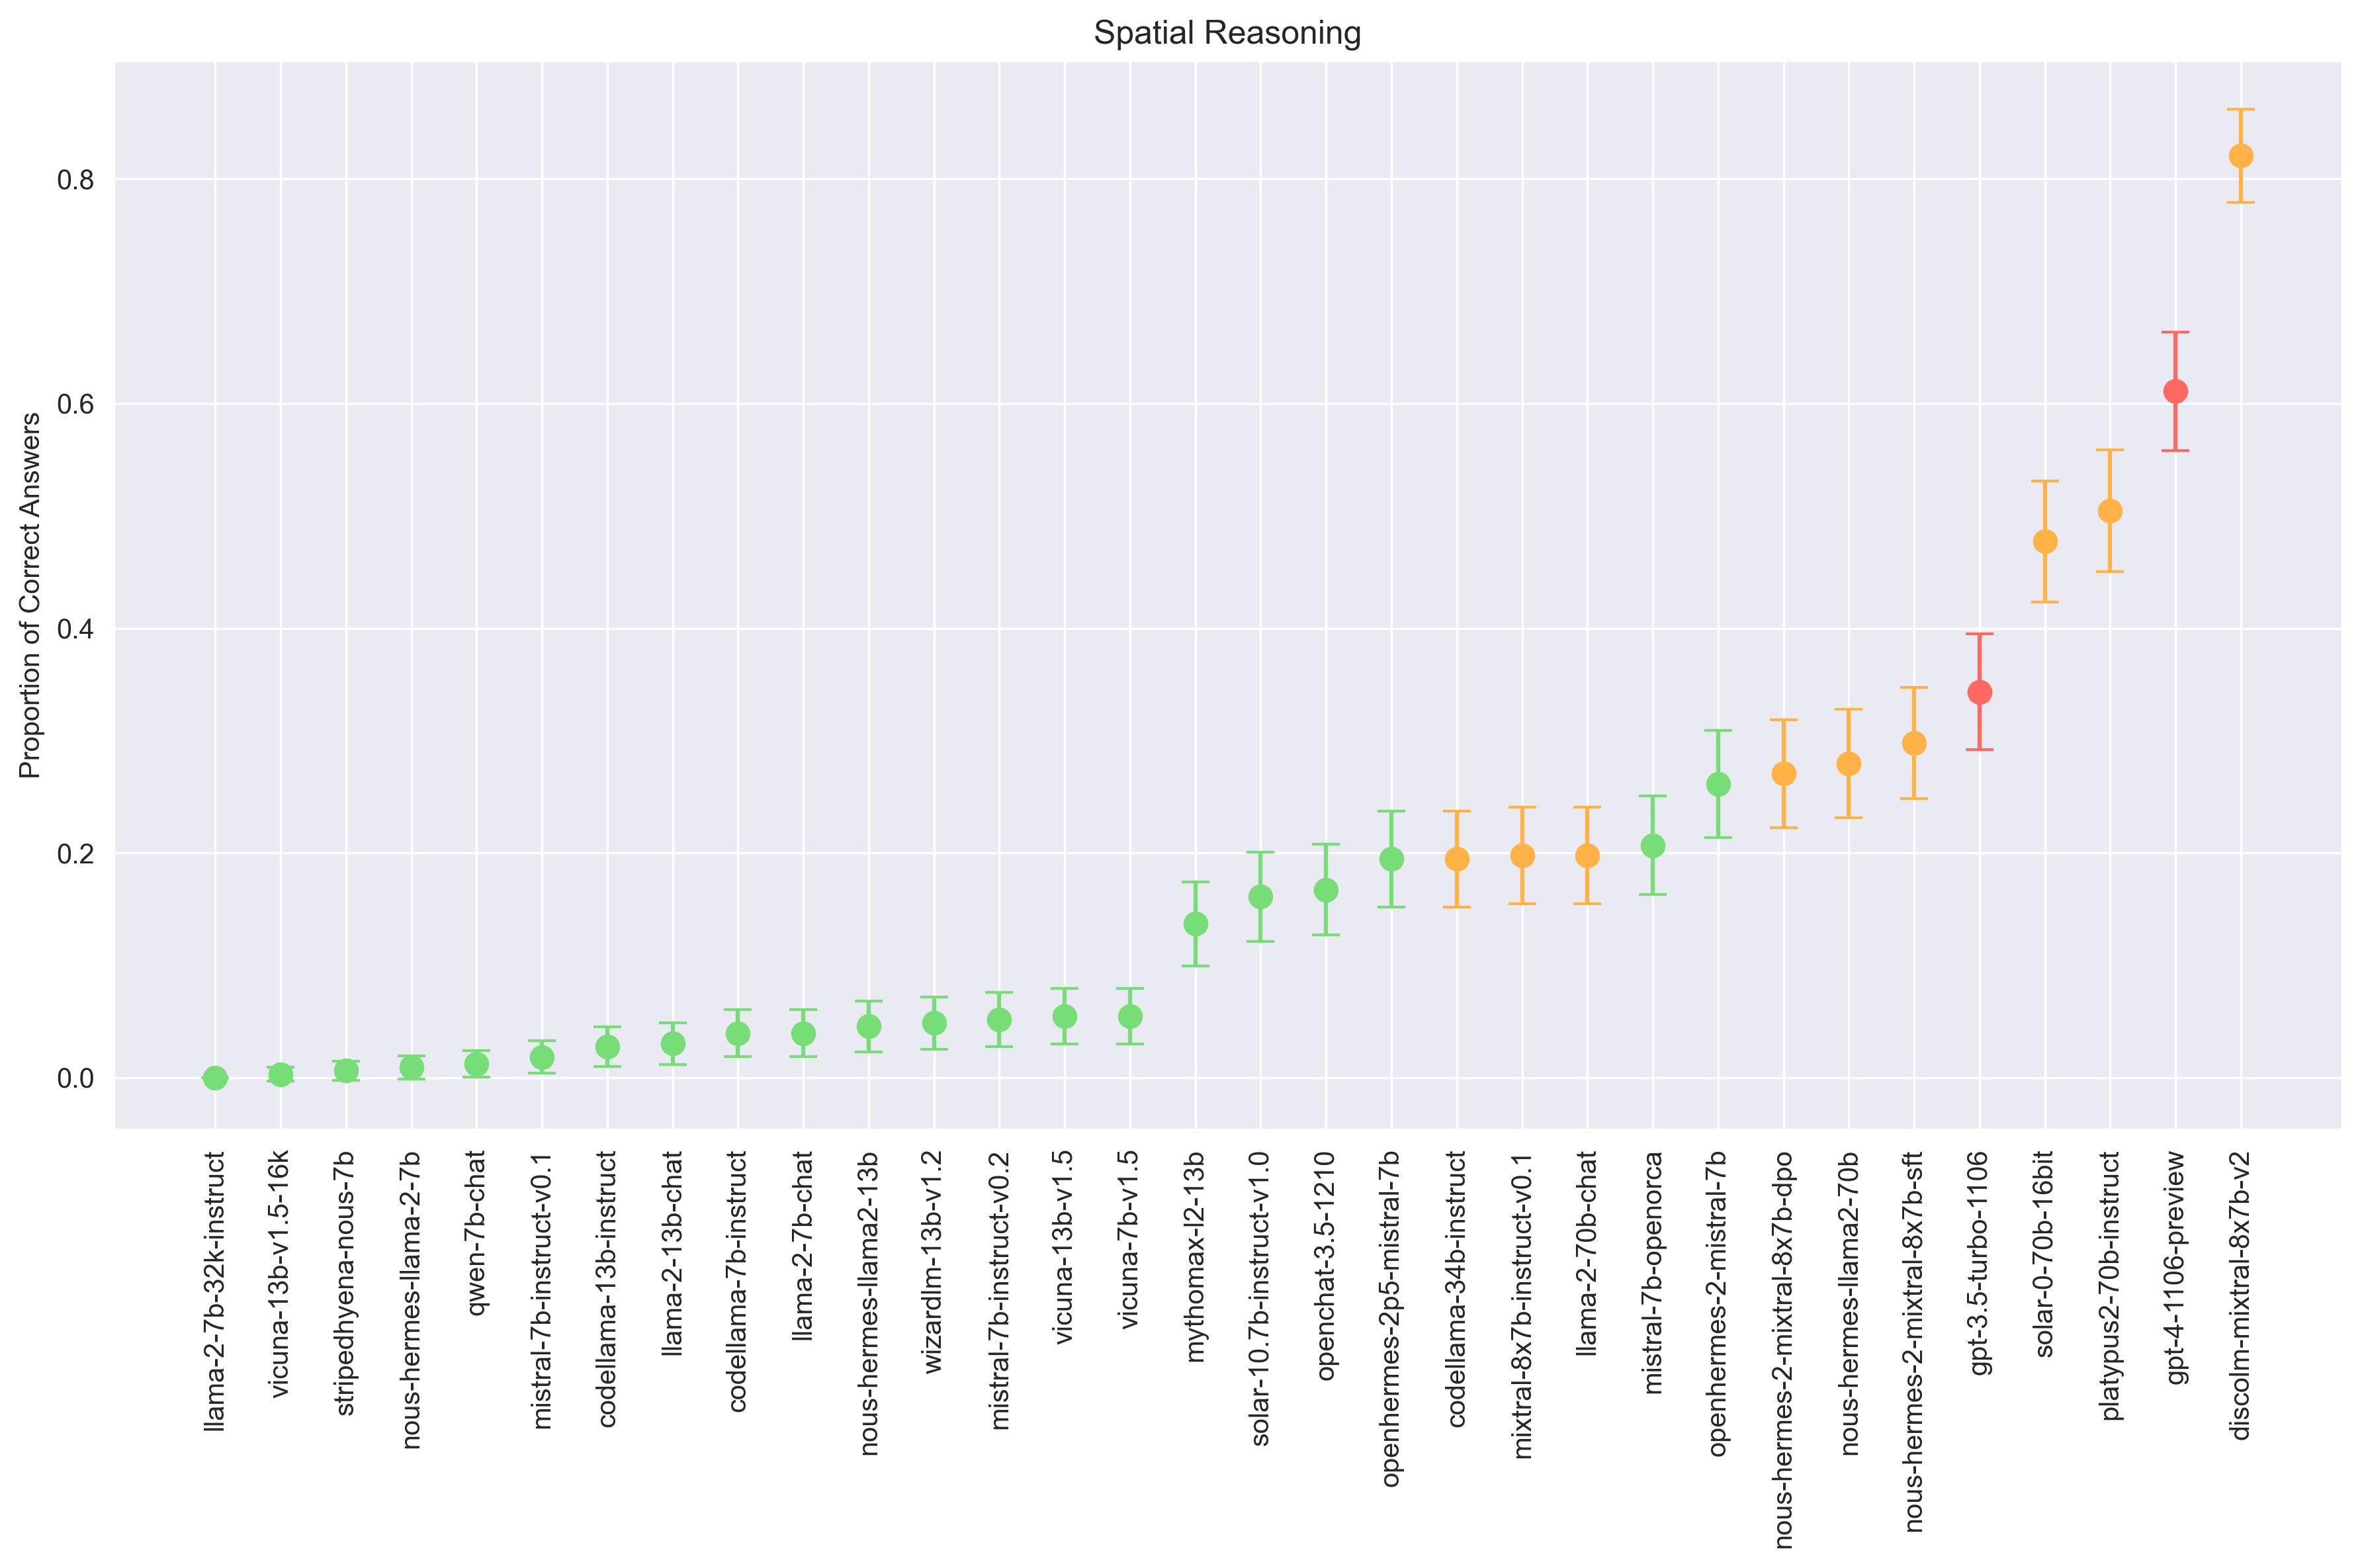

In [15]:
plot_scores("spatial_reasoning", scores, model_sizes, bad_models);

l## Dependency Cascade

In [22]:
class CascadeTopicList(BaseModel):
    topics: conlist(str, min_length=30, max_length=70) = Field(description="List of 50 topics.")
    
class CascadeValidator(BaseModel):
    analysis: str = Field(description="Detailed analysis of the proposed answer.") 
    valid: bool = Field(description="Whether the proposed answer is valid given the rules.")
    
class EventsCascade(BaseModel):
    events: conlist(Tuple[str, str], min_length=5, max_length=5) = Field(description="Ordered list of 5 event-dependency tuples, e.g.: (event, dependency).")
    validation: Optional[CascadeValidator] = None
        
    def validation_prompt(self):
        return f""" Below you will be presented with a series of events and their dependencies. Your task is to determine if the events are valid given the dependencies and if they cannot be arranged in any other way. First analyze carefully the events and dependencies, then determine their valid status.

CASCADE: {self.events}
"""

### Create Passage Topics

In [82]:
cascade_topics = client.chat.completions.create(
    model="gpt-4-1106-preview",
    response_model=CascadeTopicList,
    temperature=0.2,
    messages=[{"role": "user", "content": "Provide me with 50 topic names that could be candidates for an engaging event-based documentary. For example, 'Bioluminecent Plant Discovery', 'Drug Trafficking Network Dismantled', 'Rare Mineral Discovery', and so on. Do not use these topics, but name your topics in a similar fashion. Make all your topics simple and engaging."}]
)

In [83]:
cascade_topics

CascadeTopicList(topics=['The Great Barrier Reef Revival', 'Antarctic Ice Shelf Collapse', 'Amazon Rainforest Preservation Efforts', 'The Rise of Electric Vehicles', 'Solar Power Breakthrough', 'Deep Sea Exploration Advances', 'Wildlife Trafficking Crackdown', 'Coral Bleaching Solutions', 'Plastic Pollution Cleanup Innovations', 'Renewable Energy Milestones', 'Artificial Intelligence in Medicine', 'Cybersecurity in the Digital Age', 'Quantum Computing Revolution', 'Space Tourism Takes Off', 'Mars Colonization Plans', 'The Future of Urban Farming', 'Ocean Acidification Countermeasures', 'Mass Extinction Prevention Strategies', 'Climate Change Mitigation Successes', 'Pandemic Response and Preparedness', 'Global Water Scarcity Solutions', 'Breakthroughs in Cancer Treatment', 'Gene Editing Ethical Debates', 'Revolutionizing Education with Technology', 'The Gig Economy Transformation', 'Cryptocurrency and Financial Markets', 'The eSports Explosion', 'Virtual Reality Entertainment Boom', 'Au

### Create Cascades

In [86]:
def get_cascade_prompt(topic):
    cascade_prompt = f"""Your task is to create a "Sequential Logic Cascade" based on the topic '{topic}'. Each scenario should consist of a series of five events with strict, non-interchangeable dependencies. Make sure that the events could not happen in any other order and that events could absolutely not happened without their dependencies. You can take inspiration from the example below, but do not make your response too similar.

EXAMPLE CASCADE
================
### Topic
Bioluminescent Plant Discovery

### Events & Dependencies
- Event A: A new species of bioluminescent plant is discovered in a deep-sea expedition.
    * Dependency: The discovery of the plant is the basis for all subsequent events.
- Event B: Scientists sequence the genome of the bioluminescent plant.
    * Dependency: Requires the plant's discovery and access to advanced genetic sequencing technology.
- Event C: A breakthrough in synthetic biology enables the replication of bioluminescent genes in other plants.
    * Dependency: Directly dependent on understanding the bioluminescent plant's genome.
- Event D: The first bioluminescent trees are grown in a controlled lab environment.
    * Dependency: Can only occur after the successful replication of bioluminescent genes.
- Event E: These bioluminescent trees are introduced into urban areas to reduce the need for streetlights.
    * Dependency: Occurs only after the trees have been successfully grown and proven safe and effective in a lab.
"""
    return cascade_prompt

In [88]:
cascades = []
for cascade_topic in tqdm(cascade_topics.topics):
    cascade = client.chat.completions.create(
        model="gpt-4-1106-preview",
        response_model=EventsCascade,
        temperature=0.2,
        messages=[{"role": "user", "content": get_cascade_prompt(cascade_topic)}]
    )
    cascades.append(cascade)

print(cascades[0])

  0%|          | 0/1 [00:00<?, ?it/s]

events=[('Event A: Theoretical framework for quantum computing is established.', 'Dependency: This is the fundamental scientific understanding that allows for the conceptualization of quantum computing.'), ('Event B: Physical realization of the first qubit.', 'Dependency: Requires the theoretical framework to be established and practical experimentation in quantum mechanics.'), ('Event C: Development of the first quantum algorithm.', 'Dependency: Directly dependent on the existence of qubits to run the algorithm.'), ('Event D: Construction of the first small-scale quantum computer.', 'Dependency: Can only occur after the development of quantum algorithms that need to be tested on actual quantum hardware.'), ('Event E: Quantum computers surpass classical computers in certain tasks (quantum supremacy).', 'Dependency: Occurs only after the successful construction and testing of quantum computers.')] validation=None


### Validate Cascades

In [ ]:
for cascade in tqdm(cascades):
    cascade_validator = client.chat.completions.create(
        model="gpt-4-1106-preview",
        response_model=CascadeValidator,
        messages=[{"role": "user", "content": cascade.validation_prompt()}]
    )
    cascade.validation = cascade_validator

### Save

In [ ]:
## Remove invalid cascades.
cascades = [cascade for cascade in cascades if cascade.validation.valid]

## Store as JSON.
with open("sequential_logic_cascade.json", "w") as f:
    json.dump([cascade.model_dump() for cascade in cascades], f)
    
## As CSV.
df = pd.DataFrame([cascade.model_dump() for cascade in cascades])
df.to_csv("sequential_logic_cascade.csv", index=False)

## Hypothesis Testing

In [19]:
class HypothesisTopicList(BaseModel):
    topics: conlist(str, min_length=30, max_length=70) = Field(description="List of 50 scientific hypothesis topics.")
    

class EvidenceValidator(BaseModel):
    analysis: str = Field(description="Analysis of weather the evidence supports the hypothesis or not, and the correctness of the 'supports' flag.")
    valid: bool = Field(description="Whether the 'supports' flag is correct or not.")


class Evidence(BaseModel):
    evidence: str = Field(description="Evidence related to the hypothesis.")
    supports: str = Field(description="Whether the evidence supports, refutes or is neutral to the hypothesis. Possible values are 'Supports', 'Refutes' and 'Neutral'.")
    validation: Optional[EvidenceValidator] = None
    
    def validation_prompt(self, hypothesis):
        return f""" Below you will be presented with a hypothesis, a piece of evidence related to it and an assessment of whether the evidence supports, refutes or is neutral to the hypothesis. Your task is to determine if the assessment is correct.
HYPOTHESIS: {hypothesis}
EVIDENCE: {self.evidence}
ASSESSMENT: {self.supports}
"""

class HypothesisTest(BaseModel):
    hypothesis: str = Field(description="Hypothesis to be tested.")
    evidence: conlist(Evidence, min_length=5, max_length=5) = Field(description="List of evidence to be tested against the hypothesis.")
    validation: Optional[PuzzleValidator] = None

### Create Hypothesis Topics

In [5]:
 hypothesis_topics = client.chat.completions.create(
    model="gpt-4-1106-preview",
    response_model=HypothesisTopicList,
    temperature=0.2,
    messages=[{"role": "user", "content": "Provide me with 50 scientific hypothesis that could be subject to testing. For example, 'Eating a diet high in fruits and vegetables leads to better cardiovascular health.', 'The presence of water on a planet is a necessary condition for life.', 'The use of antibiotics in livestock leads to antibiotic resistance in humans.', and so on. Do not use these hypothesis, but name your hypothesis in a similar fashion. Make all your hypothesis simple and engaging."}]
)

In [6]:
hypothesis_topics

HypothesisTopicList(topics=['Regular exercise improves cognitive function in the elderly.', 'Consuming probiotics daily enhances the human immune system.', 'Sleeping less than six hours a night increases the risk of obesity.', 'Exposure to blue light before bedtime disrupts sleep quality.', 'Plant-based diets reduce the risk of developing type 2 diabetes.', 'Meditation reduces symptoms of anxiety and depression.', 'Children who learn a musical instrument perform better academically.', 'Drinking green tea daily can lower the risk of certain cancers.', 'Social media use is correlated with increased feelings of loneliness.', 'Bilingual individuals have a lower risk of developing dementia.', 'Dark chocolate consumption improves brain function.', 'Air pollution is associated with higher rates of asthma in urban areas.', 'Introducing allergenic foods early in life decreases the risk of allergies.', 'Video game play enhances visual-spatial skills.', 'Urban green spaces contribute to improved 

### Create Hypothesis Tests

In [20]:
def get_hypothesis_prompt(topic):
    hypothesis_prompt = f"""Your task is to create a hypothesis test for the hypothesis '{topic}'. The test should consist of a hypothesis and five pieces of evidence that either support, refute or are neutral to the hypothesis. You can take inspiration from the example below, but do not make your response too similar.
    
EXAMPLE HYPOTHESIS TEST
=======================    
### Hypothesis
Eating a diet high in fruits and vegetables leads to better cardiovascular health.
    
### Evidence
- Evidence 1: A published study showing lower blood pressure in individuals eating more greens. (Supports)
- Evidence 2: A recent survey linking high fruit consumption to reduced cholesterol levels. (Supports)
- Evidence 3: An article arguing that genetics play a more significant role in cardiovascular health than diet. (Refutes)
- Evidence 4: A case study where no significant health improvement was seen in individuals who increased their fruit and vegetable intake. (Refutes)
- Evidence 5: A nutritionist stating the importance of a balanced diet, including fruits and vegetables, for overall health. (Neutral)
"""
    return hypothesis_prompt

In [21]:
hypothesis_tests = []
for hypothesis_topic in tqdm(hypothesis_topics.topics):
    hypothesis_test = client.chat.completions.create(
        model="gpt-4-1106-preview",
        response_model=HypothesisTest,
        temperature=0.2,
        messages=[{"role": "user", "content": get_hypothesis_prompt(hypothesis_topic)}]
    )
    hypothesis_tests.append(hypothesis_test)

  0%|          | 0/1 [00:00<?, ?it/s]

### Validate Hypothesis Tests

In [22]:
for hypothesis_test in tqdm(hypothesis_tests):
    for evidence in hypothesis_test.evidence:
        evidence_validator = client.chat.completions.create(
            model="gpt-4-1106-preview",
            response_model=EvidenceValidator,
            messages=[{"role": "user", "content": evidence.validation_prompt(hypothesis_test.hypothesis)}]
        )
        evidence.validation = evidence_validator

  0%|          | 0/1 [00:00<?, ?it/s]

### Save

In [ ]:
## Remove invalid evidence-supports pairs from hypothesis tests.
for hypothesis_test in hypothesis_tests:
    hypothesis_test.evidence = [evidence for evidence in hypothesis_test.evidence if evidence.validation.valid]

## Store as JSON.
with open("hypothesis_testing.json", "w") as f:
    json.dump([hypothesis_test.model_dump() for hypothesis_test in hypothesis_tests], f)
    
## As CSV.
df = pd.DataFrame([hypothesis_test.model_dump() for hypothesis_test in hypothesis_tests])
df.to_csv("hypothesis_testing.csv", index=False)